<a href="https://colab.research.google.com/github/sanduerhan/Licenta/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Import

In [19]:
#importing the dataset
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import openpyxl
from nltk.corpus import stopwords, words, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string
from string import punctuation, digits
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.initializers import Constant
from keras import layers
from keras.layers import ReLU
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

col_list = ["Column2", "Column3"]
dataset = pd.read_excel("Training.data.xlsx", usecols=col_list)
testset = pd.read_excel("Dev.xlsx", usecols=col_list)


def add_category_id(dataset):
  dataset['category_id'] = dataset['Column3'].factorize()[0]
  category_id_dataset = dataset[['Column3', 'category_id']].drop_duplicates()

  category_to_id = dict(category_id_dataset.values)
  id_to_category = dict(category_id_dataset[['category_id', 'Column3']].values)
  return dataset,category_to_id, id_to_category

dataset, category_to_id_train, id_to_category_train = add_category_id(dataset)
testset, category_to_id_test, id_to_category_test = add_category_id(testset)

train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]


dataset.tail()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Column2,Column3,category_id
8063,Ways to reverse memory loss from depression? :...,severe,2
8064,A Comprehensive Guide To Slowly Getting Better...,severe,2
8065,I don’t think college is right for me : TW: su...,severe,2
8066,Please help: Severe insomnia affecting me in m...,severe,2
8067,With each passing day my depression is getting...,severe,2


In [172]:
train_tweets = dataset['Column2'].tolist()
test_tweets = testset['Column2'].tolist()
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['Column2'] == i ].index, inplace=True)
    return df

dataset = keep_uniques(train_tweets, dataset)
testset = keep_uniques(test_tweets, testset)

print(len(dataset))

1591


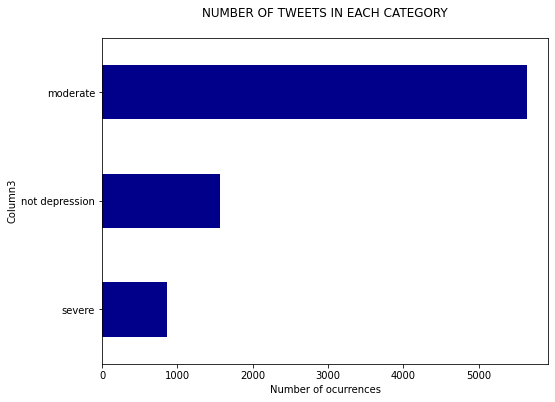

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue','darkblue']
dataset.groupby('Column3').Column2.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

# PreProcessing

In [21]:
# !pip install tweet-preprocessor
import preprocessor as p

def preprocess_tweets(text):
  return p.clean(text)

print(preprocess_tweets(train_x[0]))

Waiting for my mind to have a breakdown once the New Year feeling isnt there anymore : I dont know about anyone else, but Im a little bit worried that Ill go back to being depressed in a few days time or something. Last year, I tried not to have any breakdowns for the start of . A mere days later, I broke down crying. I wasnt the same for that entire year. Up until December, where I was ok that month. Now I just wait... its a weird way to act and feel, but it feels a bit normal.


In [24]:
# cleaning the text : deleting the emojis, the existing emails, the punctuation, the present digits,
# the hyperlinks and the stopwords (a,the,is, etc)

def delete_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)  # no emoji


def delete_digits(text):
    text = text.lower()
    clean = text.translate(str.maketrans('', '', digits))
    return clean


def delete_punctuation(text):
    clean = text.translate(str.maketrans('', '', punctuation + '’“”'))
    return clean


stop = set(stopwords.words('english'))
stop.add('gtpoplt')
stop.add('new')
stop.add('year')
stop.add('eve')
stop.add('years')
stop.add('ti')
stop.add('ame')
stop.add('folks')
punct = list(string.punctuation)
stop.update(punct)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def remove_hyperlinks(text):
    for word in text:
        if re.match(r'^http', word):
            text.remove(word)
    return " ".join(text)

def remove_emails(text):
    text = text.split()
    for i in text:
        if '@' in i.strip().lower():
            text.remove(i)
    return " ".join(text)

contraction_dict = {"youre":"you are","im": "i am","wouldnt": "would not","itll": "it will","wasnt": "was not","dont": "do not","ill": "i will","isnt": "is not","cant": "cannot","arent": "are not","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# def denoise_text(text):
#     text = replace_contractions(text)
#     text = remove_words(text)
#     text = remove_emails(text)
#     text = delete_punctuation(text)
#     text = delete_emoji(text)
#     text = delete_digits(text)
#     text = remove_stopwords(text)
#     text = text.split()
#     text = remove_hyperlinks(text)
#     return text



train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]

for i in range(len(train_x)):
  train_x[i] = replace_contractions(train_x[i])
  train_x[i] = remove_emails(train_x[i])
  train_x[i] = delete_punctuation(train_x[i])
  train_x[i] = delete_emoji(train_x[i])
  train_x[i] = delete_digits(train_x[i])
  train_x[i] = remove_stopwords(train_x[i])


preserve_unused_tokens=False:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
preserve_unused_tokens=False:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
preserve_unused_tokens=False:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
preserve_unused_tokens=False:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [25]:
print(train_x[0])

waiting mind breakdown feeling anymore know anyone else little bit worried go back depressed days something last tried breakdowns start mere days later broke crying entire december ok month wait weird way act feel feels bit normal


# Lemmatization

In [26]:
# lemmatization : crying -> cry, days -> day

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemm(text):
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    sar_list_lemmatizer = [lemmatizer.lemmatize(word, get_pos(word)) for word in text]
    return " ".join(sar_list_lemmatizer)

train_x = train_x.apply(lemm)
test_x = test_x.apply(lemm)

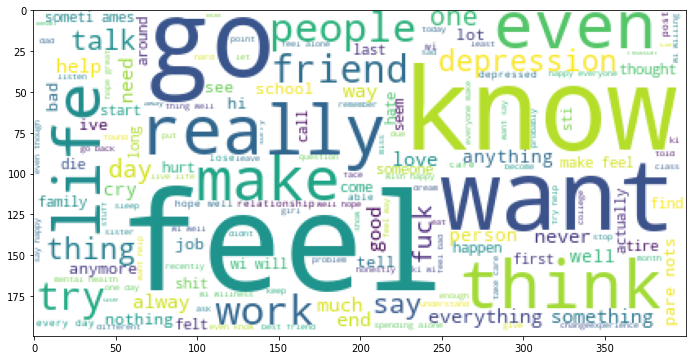

In [290]:
from wordcloud import WordCloud

plt.figure(figsize=(12,6))
text = ' '.join(train_x[dataset['Column3']=='not depression'])
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

# Count Vectorizer

In [291]:
# CountVectorizer reprezentation for the user tweets
vectorizer = CountVectorizer()
x_train_cv = vectorizer.fit_transform(train_x)

x_test_cv = vectorizer.transform(test_x)
print(x_train_cv.shape)

(8068, 10252)


# Data imbalance handling

In [292]:
sm = SMOTE(random_state = 42)
res_x, res_y = sm.fit_resample(x_train_cv, train_y)
print("After OverSampling, counts of label '2': {}".format(sum(res_y == 2)))

After OverSampling, counts of label '2': 5647


In [45]:
os = RandomOverSampler()
res_x2, res_y2 = os.fit_resample(x_train_cv, train_y)

# Tf-Idf 

In [ ]:
# Tf-idf reprezentation for the tweets
from sklearn.feature_selection import chi2
vectorizer = TfidfVectorizer(max_df = 0.15,min_df = 5, ngram_range=(1,2), stop_words='english')
train_x_tf = vectorizer.fit_transform(train_x)
test_x_tf = vectorizer.transform(test_x)
N = 2
for Product, category_id in sorted(category_to_id_train.items()):
    features_chi2 = chi2(train_x_tf, train_y == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
res_tfx, res_tfy = sm.fit_resample(train_x_tf, train_y)
print(train_x_tf.shape)
print(res_tfx.shape)

# Naive Bayes

In [294]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_x, res_y)
pred_y = naive_bayes_classifier.predict(x_test_cv)

score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y))

Accuracy 0.4230014713094654
              precision    recall  f1-score   support

           0       0.57      0.32      0.41      2198
           1       0.39      0.62      0.48      1522
           2       0.16      0.20      0.18       358

    accuracy                           0.42      4078
   macro avg       0.38      0.38      0.36      4078
weighted avg       0.47      0.42      0.42      4078



In [295]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_tfx, res_tfy)
# naive_bayes_classifier.fit(train_x_tf, train_y)
pred_y = naive_bayes_classifier.predict(test_x_tf)
score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y))

Accuracy 0.3048062775870525
              precision    recall  f1-score   support

           0       0.56      0.27      0.36      2198
           1       0.51      0.23      0.32      1522
           2       0.13      0.85      0.23       358

    accuracy                           0.30      4078
   macro avg       0.40      0.45      0.30      4078
weighted avg       0.50      0.30      0.33      4078



# AdaBoost

In [296]:
# res_x2, res_y2 = sm.fit_resample(train_x_tf, train_y)
ada = AdaBoostClassifier()

# boost = ada.fit(train_x_tf, train_y)
boost = ada.fit(res_tfx, res_tfy)
pred_y = boost.predict(test_x_tf)
print("AdaBoost Classifier Model Accuracy:", accuracy_score(test_y, pred_y))
print(metrics.classification_report(test_y, pred_y))

AdaBoost Classifier Model Accuracy: 0.4681216282491417
              precision    recall  f1-score   support

           0       0.61      0.35      0.45      2198
           1       0.46      0.64      0.54      1522
           2       0.23      0.43      0.30       358

    accuracy                           0.47      4078
   macro avg       0.43      0.48      0.43      4078
weighted avg       0.52      0.47      0.47      4078



# Regression

In [300]:
model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3)
model = model.fit(res_tfx,res_tfy)
y_pred = model.predict(test_x_tf)
print("Regression Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))


import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)
# fig, ax = plt.subplots(figsize=(3,3))
# sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
#             xticklabels=dataset.Column3.values, 
#             yticklabels=dataset.Column3.values)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title("CONFUSION MATRIX \n", size=16);

Regression Classifier Model Accuracy: 0.5213339872486513
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      2198
           1       0.50      0.40      0.44      1522
           2       0.29      0.56      0.38       358

    accuracy                           0.52      4078
   macro avg       0.47      0.52      0.48      4078
weighted avg       0.54      0.52      0.52      4078

[[1319  553  326]
 [ 752  607  163]
 [ 102   56  200]]


In [303]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model = model.fit(res_tfx,res_tfy)
y_pred = model.predict(test_x_tf)
print("Svc Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))


import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


Svc Classifier Model Accuracy: 0.513241785188818
              precision    recall  f1-score   support

           0       0.61      0.55      0.58      2198
           1       0.48      0.46      0.47      1522
           2       0.28      0.48      0.35       358

    accuracy                           0.51      4078
   macro avg       0.46      0.50      0.47      4078
weighted avg       0.53      0.51      0.52      4078

[[1218  691  289]
 [ 662  702  158]
 [ 116   69  173]]


# Word2Vec

In [302]:
# Word2Vec reprezentation

corpus_text = 'n'.join(train_x)
# corpus_text = 'n'.join(res_x)
data = []
# iterate through each sentence in the file
for i in sent_tokenize(corpus_text):
    temp = []
    # tokenize the sentence into words
    for j in word_tokenize(i):
        temp.append(j.lower())
    data.append(temp)

model1 = gensim.models.Word2Vec(min_count = 5,size = 300, window = 5, alpha = 0.025)
model1.build_vocab(data)
print(len(model1.wv.vocab))
model1.train(data, total_examples = model1.corpus_count, epochs=30)

print(model1.wv.most_similar(positive=["depression"]))

vocab = list(model1.wv.vocab.keys())

word2vec_dict ={}
for word in vocab:
  word2vec_dict[word] = model1.wv.get_vector(word)

maxi=-1
for i,rev in enumerate(train_x):
  tokens=rev.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)
# print(maxi)



tok = Tokenizer()
tok.fit_on_texts(train_x)
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(train_x)

max_len = 1464
embed_dim = 300
pad_rev = pad_sequences(encd_rev, maxlen=max_len, padding='post')

# print(pad_rev.shape)

5934
[('hi', 0.9998937845230103), ('anxiety', 0.9998897910118103), ('idea', 0.9998865127563477), ('beer', 0.9998855590820312), ('bottom', 0.9998793601989746), ('ammunity', 0.9998791813850403), ('destroyed', 0.9998780488967896), ('maybe', 0.9998770356178284), ('go', 0.9998758435249329), ('deficiency', 0.9998757839202881)]


# Neural Network

In [241]:

embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word2vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
# train = []
# for row in train_y:
#   if row == "moderate":
#     train.append(1)
#   elif row == "severe":
#     train.append(2)
#   elif row == "not depression":
#     train.append(0)

Y=keras.utils.to_categorical(train_y)  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.25,random_state=42)

model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_len,embeddings_initializer=Constant(embed_matrix)))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
loss='categorical_crossentropy',metrics=['accuracy'])


model=model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test,y_test))
# pred_y = model.predict(x_test)
# metrics.classification_report(y_test, pred_y)

Epoch 1/5
95/95 [==============================] - 24s 244ms/step - loss: 1.2282 - accuracy: 0.6870 - val_loss: 0.8593 - val_accuracy: 0.6946
Epoch 2/5
95/95 [==============================] - 20s 211ms/step - loss: 0.9533 - accuracy: 0.7029 - val_loss: 0.9620 - val_accuracy: 0.7124
Epoch 3/5
95/95 [==============================] - 20s 210ms/step - loss: 0.8426 - accuracy: 0.7047 - val_loss: 0.7381 - val_accuracy: 0.7040
Epoch 4/5
95/95 [==============================] - 20s 210ms/step - loss: 0.7709 - accuracy: 0.7110 - val_loss: 0.7704 - val_accuracy: 0.7030
Epoch 5/5
95/95 [==============================] - 20s 211ms/step - loss: 0.6655 - accuracy: 0.7172 - val_loss: 0.7049 - val_accuracy: 0.7263


# BERT

In [67]:
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

label = preprocessing.LabelEncoder()
y = label.fit_transform(train_y)
train_y = to_categorical(y)

print(train_y[:5])

m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

ValueError: ignored

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install bert-tensorflow==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

NameError: ignored

In [316]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(5, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [53]:
max_len = 250
train_input = bert_encode(train_x, tokenizer, max_len=max_len)
test_input = bert_encode(test_x, tokenizer, max_len=max_len)
train_labels = y

labels = label.classes_
print(labels)

model = build_model(bert_layer, max_len=max_len)
model.summary()

NameError: ignored

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.3 MB/s 
     |████████████████████████████████| 86 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 18.7 MB/s 
     |████████████████████████████████| 6.6 MB 12.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
from transformers import RobertaTokenizer
TOKENIZER = RobertaTokenizer.from_pretrained("roberta-base")


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Encode: [0, 16040, 20414, 162, 328, 2]
Decode: <s>Encode me!</s>


In [12]:
from transformers import BertTokenizer
TOKENIZER = BertTokenizer.from_pretrained('google/electra-base-generator')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [13]:
from transformers import TFBertModel, BertModel
bert_base = TFBertModel.from_pretrained('bert-base-uncased')
#bert_base = BertModel.from_pretrained('bert-base-uncased')          #to use with PyTorch

#select BERT tokenizer
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [32]:
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data)):
        encoded = TOKENIZER.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [62]:
BATCH_SIZE = 16

#how many epochs?
EPOCHS = 2

#clean Tweets?
CLEAN_TWEETS = False

#use meta data?
USE_META = False

#add dense layer?
ADD_DENSE = False
DENSE_DIM = 64

#add dropout?
ADD_DROPOUT = True
DROPOUT = .2

#train BERT base model? 
TRAIN_BASE = True
def build_model(model_layer, learning_rate, use_meta = USE_META, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    # meta_input = tf.keras.Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    output = transformer_layer[1]
    
    #add meta data
    # if use_meta:
    #     output = tf.keras.layers.Concatenate()([output, meta_input])
    
    #add dense relu layer
    if add_dense:
        print("Training with additional dense layer...")
        output = tf.keras.layers.Dense(dense_dim,activation='relu')(output)
    
    #add dropout
    if add_dropout:
        print("Training with dropout...")
        output = tf.keras.layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = tf.keras.layers.Dense(3,activation='softmax')(output)
    
    #assemble and compile
    if use_meta:
        print("Training with meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)
    
    else:
        print("Training without meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'], color = '#171820')
    ax[0].plot(history.history['val_accuracy'], color = '#fdc029')

    ax[1].plot(history.history['loss'], color='#171820')
    ax[1].plot(history.history['val_loss'], color = '#fdc029')

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Learning Curves", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [33]:
if TRAIN_BASE:
    #get our inputs
    print('Encoding Tweets...')
    train_input_ids,train_attention_masks = bert_encode(train_x,60)
    test_input_ids,test_attention_masks = bert_encode(test_x,60)
    print('Tweets encoded')
    print('')

    #debugging step
    print('Train length:', len(train_input_ids))
    print('Test length:', len(test_input_ids))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Encoding Tweets...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tweets encoded

Train length: 8068
Test length: 4078


In [63]:
BERT_base = build_model(bert_base, learning_rate = 1e-5)
BERT_base.summary()

Training with dropout...
Training without meta-data...
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_17[0][0]',               
                                thPoolingAndCrossAt               'input_18[0][0]']               
                                tentions(last_hidde                                               
                                n_sta

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('base_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [69]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
if TRAIN_BASE:
    if USE_META:
        history = BERT_base.fit([train_input_ids,train_attention_masks, meta_train], train.target, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
    
    else:
        history = BERT_base.fit([train_input_ids,train_attention_masks], train_y, validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/2
404/404 [==============================] - 4653s 12s/step - loss: 0.2325 - accuracy: 0.9264 - val_loss: 5.3807 - val_accuracy: 0.0688
Epoch 2/2
404/404 [==============================] - 4371s 11s/step - loss: 0.0913 - accuracy: 0.9799 - val_loss: 6.5829 - val_accuracy: 0.0867
